In [51]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')
from src.data.functions import safe_log, convert_datetime
from src.utils.directories import get_parent_directory

from src.features.calc_seaice import calc_SIC
from src.features.processing_func import mld
from src.utils.directories import get_parent_directory

In [33]:
parent_dir = get_parent_directory()

# five cruises from the Nansen Legacy

# MSS, so dimensions of profile and time
GOS2020113_nc = os.path.join(parent_dir, "data/external/Microstructure/nansen_legacy/GOS2020113/MERGED_EPSI.nc")
GOS2020113_ds = xr.open_dataset(GOS2020113_nc)

# MSS, so dimensions of profile and time
KH2021702_nc = os.path.join(parent_dir, "data/external/Microstructure/nansen_legacy/KH2021702/MERGED_EPSI.nc")
KH2021702_ds = xr.open_dataset(KH2021702_nc)

# MSS, so dimensions of profile and time
KB2022625_nc = os.path.join(parent_dir, "data/external/Microstructure/nansen_legacy/KB2022625/MERGED_EPSI.nc")
KB2022625_ds = xr.open_dataset(KB2022625_nc)

# VMP, so dimensions of profile and depth
KH2018709_nc = os.path.join(parent_dir, "data/external/Microstructure/nansen_legacy/KH2018709/KH2018709_VMP.nc")
KH2018709_ds = xr.open_dataset(KH2018709_nc)

# VMP, so dimensions of profile and depth
KB2018616_nc = os.path.join(parent_dir, "data/external/Microstructure/nansen_legacy/KB2018616/KB2018616_VMP.nc")
KB2018616_ds = xr.open_dataset(KB2018616_nc)

## Convert VMP into profile, depth dimensions

These are already binned to 1m

In [34]:
KH2018709_ds["profile"] = KH2018709_ds["TIME"].count()
KH2018709_ds['profile'] = xr.DataArray(range(1,len(KH2018709_ds['TIME'])+1), dims='TIME')
KH2018709_ds = KH2018709_ds.swap_dims({'TIME': 'profile'})

In [35]:
KB2018616_ds["profile"] = KB2018616_ds["TIME"].count()
KB2018616_ds['profile'] = xr.DataArray(range(1,len(KB2018616_ds['TIME'])+1), dims='TIME')
KB2018616_ds = KB2018616_ds.swap_dims({'TIME': 'profile'})

In [36]:
# Convert the time coordinate into a variable
KB2018616_ds = KB2018616_ds.assign(time=KB2018616_ds.coords["TIME"])
KH2018709_ds  = KH2018709_ds.assign(time=KH2018709_ds.coords["TIME"])

In [37]:
KB2018616_ds = KB2018616_ds.rename_vars({"LATITUDE": "latitude", "LONGITUDE": "longitude", "TEMP": "T", "PSAL": "S"})
KB2018616_ds = KB2018616_ds.rename({"DEPTH": "depth", "PRES": "P"})

KH2018709_ds = KH2018709_ds.rename_vars({"LATITUDE": "latitude", "LONGITUDE": "longitude", "TEMP": "T", "PSAL": "S"})
KH2018709_ds = KH2018709_ds.rename({"DEPTH": "depth", "PRES": "P"})

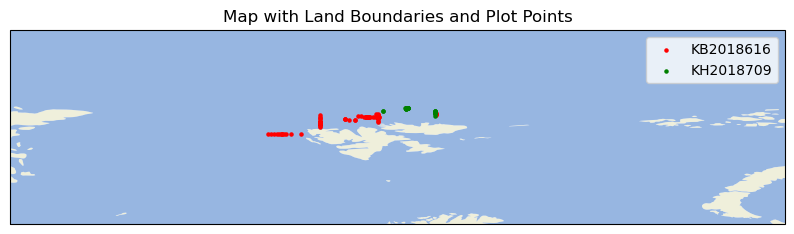

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(KB2018616_ds.longitude, KB2018616_ds.latitude, transform=ccrs.PlateCarree(), color='red', s=5, label = "KB2018616")
ax.scatter(KH2018709_ds.longitude, KH2018709_ds.latitude, transform=ccrs.PlateCarree(), color='green', s=5, label = "KH2018709")

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([-20,60, 70, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.legend()
plt.show()

## Check if it works with the variables

ensure it is in (profile, depth) shape

In [45]:
SI_HadISST = os.path.join(parent_dir, "data/external/SI-area/HadISST_ice.nc")
Hadi_SI = xr.open_dataset(SI_HadISST)

In [55]:
KB2018616_ds = KB2018616_ds.transpose("depth", "profile")
KH2018709_ds = KH2018709_ds.transpose("depth", "profile")
KB2018616_SIC = calc_SIC(KB2018616_ds, Hadi_SI)
KB2018616_MLD = mld(KB2018616_ds)

## Save in datafolder

In [61]:
# Construct the file path using the parent directory
file_pathKH2018709 = os.path.join(parent_dir, "data", "interim", "KH2018709.nc")
KH2018709_ds.to_netcdf(file_pathKH2018709)

file_pathKB2018616 = os.path.join(parent_dir, "data", "interim", "KB2018616.nc")
KB2018616_ds.to_netcdf(file_pathKB2018616)

## Convert MSS into profile, depth dimensions

assuming isotropy

In [56]:
GOS2020113_ds["DEPTH"] = np.abs(gsw.z_from_p(GOS2020113_ds["PRES"], 0)) 
GOS2020113_ds = GOS2020113_ds.assign_coords(DEPTH=GOS2020113_ds["DEPTH"])
GOS2020113_ds = GOS2020113_ds.rename_dims({"TIME_DIM": "depth", "SECTIONS": "PROFILE"})

In [57]:
GOS2020113_ds

<xarray.Dataset>
Dimensions:                (PROFILE: 206, depth: 144, N_SHEAR_SENSORS: 2)
Coordinates:
    DEPTH                  (PROFILE, depth) float64 4.376 5.712 ... nan nan
Dimensions without coordinates: PROFILE, depth, N_SHEAR_SENSORS
Data variables: (12/20)
    TIME                   (PROFILE, depth) datetime64[ns] ...
    EPSI                   (PROFILE, N_SHEAR_SENSORS, depth) float64 ...
    EPSI_FINAL             (PROFILE, depth) float64 ...
    KMAX                   (PROFILE, N_SHEAR_SENSORS, depth) float64 ...
    SECTION_NUMBER         (PROFILE, depth) int32 ...
    PSPD_REL               (PROFILE, depth) float64 ...
    ...                     ...
    MAD                    (PROFILE, N_SHEAR_SENSORS, depth) float64 ...
    VAR_RESOLVED           (PROFILE, N_SHEAR_SENSORS, depth) float64 ...
    EPSI_STD               (PROFILE, N_SHEAR_SENSORS, depth) float64 ...
    DESPIKE_PASS_COUNT_SH  (PROFILE, N_SHEAR_SENSORS, depth) float64 ...
    TRANS_ERR_FRACTION     (PROFILE, depth) float64 ...
    EPSI_FLAGS             (PROFILE, N_SHEAR_SENSORS, depth) int32 ...
Attributes: (12/53)
    title:                         Ocean microstructure measurements using an...
    summary:                       Ocean microstructure profiles were collect...
    platform_type:                 research vessel
    comment:                       Profiles were obtained using an MSS (Micro...
    conventions:                   CF-1.6, ACDD-1.3, ATOMIX
    history:                       Version 1
    ...                            ...
    despike_iterations_limit:      8.0
    HP_cut:                        0.5
    goodman:                       1.0
    creation_time:                 2023-06-08T16:21:23Z
    date_update:                   2023-06-08T16:21:23Z
    date_created:                  2023-06-08

In [125]:
GOS2020113_ds_renamed = GOS2020113_ds.rename({"EPSI_FINAL": "eps", "TEMP": "T", "LON": "longitude", "LAT": "latitude", ""})

In [88]:
GOS2020113_ds_reshaped = GOS2020113_ds.assign_coords(DEPTH=GOS2020113_ds["depth"])

KeyError: 'depth'

In [69]:
GOS2020113_ds_reshaped = GOS2020113_ds.expand_dims({"depth": GOS2020113_ds["depth"]})

ValueError: depth already exists as coordinate or variable name.

In [52]:
GOS2020113_ds

<xarray.Dataset>
Dimensions:                (SECTIONS: 206, TIME_DIM: 144, N_SHEAR_SENSORS: 2)
Dimensions without coordinates: SECTIONS, TIME_DIM, N_SHEAR_SENSORS
Data variables: (12/20)
    TIME                   (SECTIONS, TIME_DIM) datetime64[ns] ...
    EPSI                   (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    EPSI_FINAL             (SECTIONS, TIME_DIM) float64 ...
    KMAX                   (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    SECTION_NUMBER         (SECTIONS, TIME_DIM) int32 ...
    PSPD_REL               (SECTIONS, TIME_DIM) float64 ...
    ...                     ...
    MAD                    (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    VAR_RESOLVED           (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    EPSI_STD               (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    DESPIKE_PASS_COUNT_SH  (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    TRANS_ERR_FRACTION     (SECTIONS, TIME_DIM) float64 ...
    EPSI_FLAGS             (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) int32 ...
Attributes: (12/53)
    title:                         Ocean microstructure measurements using an...
    summary:                       Ocean microstructure profiles were collect...
    platform_type:                 research vessel
    comment:                       Profiles were obtained using an MSS (Micro...
    conventions:                   CF-1.6, ACDD-1.3, ATOMIX
    history:                       Version 1
    ...                            ...
    despike_iterations_limit:      8.0
    HP_cut:                        0.5
    goodman:                       1.0
    creation_time:                 2023-06-08T16:21:23Z
    date_update:                   2023-06-08T16:21:23Z
    date_created:                  2023-06-08

In [53]:
GOS2020113_ds["depth"] = gsw.z_from_p(GOS2020113_ds["PRES"], 0) 

In [55]:
GOS2020113_ds.depth

<xarray.DataArray 'depth' (SECTIONS: 206, TIME_DIM: 144)>
array([[-4.37593714, -5.71227611, -6.80682071, ...,         nan,
                nan,         nan],
       [-3.17266476, -5.30178311, -7.60939339, ...,         nan,
                nan,         nan],
       [-3.75707797, -5.1738828 , -6.78106021, ...,         nan,
                nan,         nan],
       ...,
       [-3.50339188, -5.43362081, -7.21317218, ...,         nan,
                nan,         nan],
       [-3.18334829, -4.95939588, -6.75980273, ...,         nan,
                nan,         nan],
       [-2.67181772, -3.76796691, -5.01693597, ...,         nan,
                nan,         nan]])
Dimensions without coordinates: SECTIONS, TIME_DIM
Attributes:
    standard_name:  sea_water_pressure
    units:          decibar
    long_name:      Sea water pressure, equals 0 at sea-level

In [54]:
GOS2020113_ds

<xarray.Dataset>
Dimensions:                (SECTIONS: 206, TIME_DIM: 144, N_SHEAR_SENSORS: 2)
Dimensions without coordinates: SECTIONS, TIME_DIM, N_SHEAR_SENSORS
Data variables: (12/21)
    TIME                   (SECTIONS, TIME_DIM) datetime64[ns] ...
    EPSI                   (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    EPSI_FINAL             (SECTIONS, TIME_DIM) float64 ...
    KMAX                   (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    SECTION_NUMBER         (SECTIONS, TIME_DIM) int32 ...
    PSPD_REL               (SECTIONS, TIME_DIM) float64 ...
    ...                     ...
    VAR_RESOLVED           (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    EPSI_STD               (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    DESPIKE_PASS_COUNT_SH  (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) float64 ...
    TRANS_ERR_FRACTION     (SECTIONS, TIME_DIM) float64 ...
    EPSI_FLAGS             (SECTIONS, N_SHEAR_SENSORS, TIME_DIM) int32 ...
    depth                  (SECTIONS, TIME_DIM) float64 -4.376 -5.712 ... nan
Attributes: (12/53)
    title:                         Ocean microstructure measurements using an...
    summary:                       Ocean microstructure profiles were collect...
    platform_type:                 research vessel
    comment:                       Profiles were obtained using an MSS (Micro...
    conventions:                   CF-1.6, ACDD-1.3, ATOMIX
    history:                       Version 1
    ...                            ...
    despike_iterations_limit:      8.0
    HP_cut:                        0.5
    goodman:                       1.0
    creation_time:                 2023-06-08T16:21:23Z
    date_update:                   2023-06-08T16:21:23Z
    date_created:                  2023-06-08

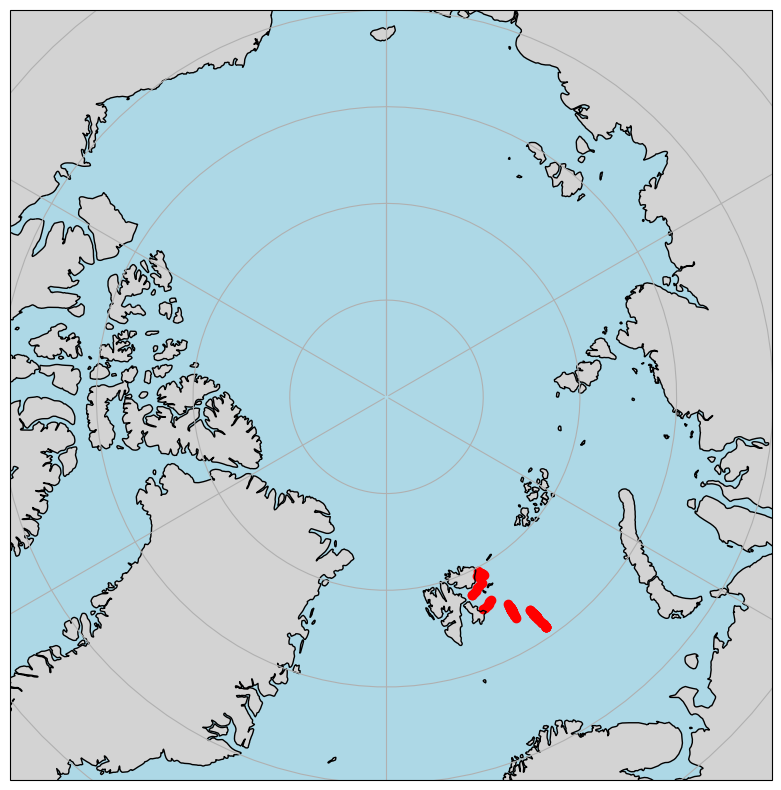

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and axes with Azimuthal Equidistant projection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AzimuthalEquidistant(central_latitude=90))

# Plot the scatter points
ax.scatter(merged_epsi.LON, merged_epsi.LAT, transform=ccrs.PlateCarree(), color='red')

# Set the map extent and projection center
ax.set_global()
ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())

# Add land and ocean color
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Show the plot
plt.show()



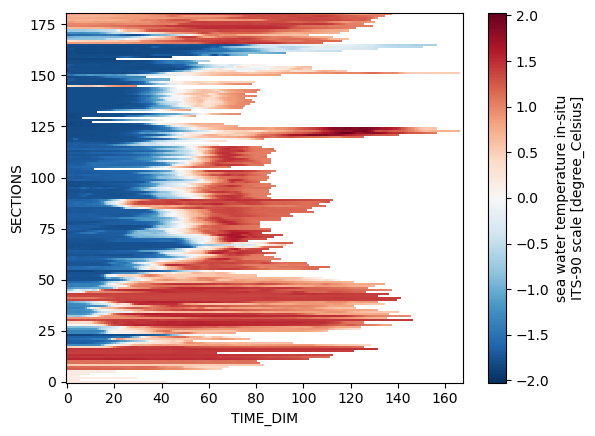

In [7]:
merged_epsi.TEMP.plot()

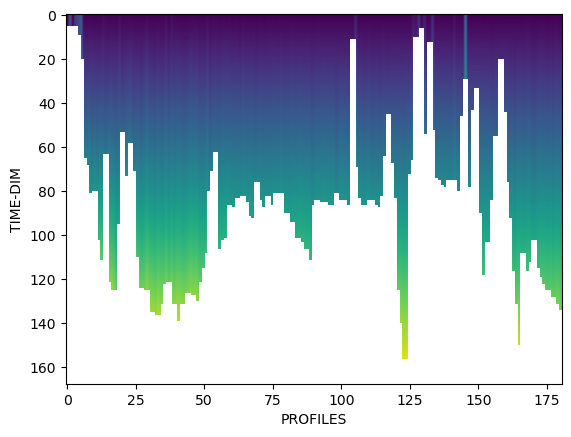

In [26]:
# Get the data for the plot
data = merged_epsi.PRES.values

# Create the plot with swapped axes
plt.imshow(np.transpose(data), aspect='auto', origin='lower')

# Set the labels for the swapped axes
plt.ylabel('TIME-DIM')
plt.xlabel('PROFILES')

# Invert the y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

(array([3.3883e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.87694114e-19, 1.70475083e+42, 3.40950166e+42, 5.11425249e+42,
        6.81900332e+42, 8.52375416e+42, 1.02285050e+43, 1.19332558e+43,
        1.36380066e+43, 1.53427575e+43, 1.70475083e+43]),
 <BarContainer object of 10 artists>)

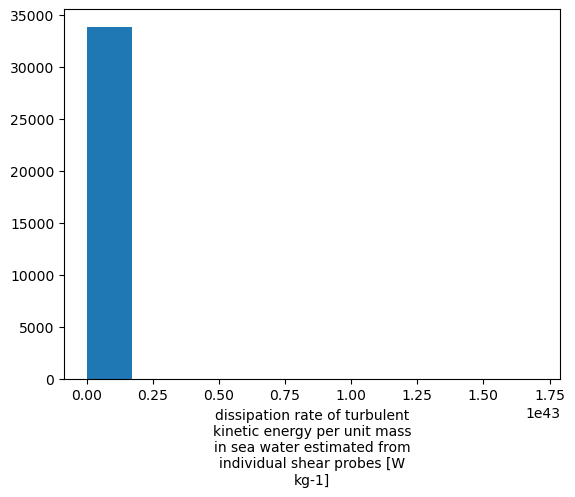

In [6]:
merged_epsi.EPSI.plot()

In [ ]:
merged_epsi

In [2]:
eps_ds = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/nansen_legacy/GOS2020113_EPSI.nc"
hi = Dataset(eps_ds)
hhh = xr.open_dataset(eps_ds)

MissingDimensionsError: 'TIME' has more than 1-dimension and the same name as one of its dimensions ('SECTIONS', 'TIME'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.

In [18]:
ctd_ds = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/nansen_legacy/GOS2020113_CTD.nc"
hallo = Dataset(ctd_ds)

In [22]:
result = pd.concat([hi, hallo], axis=0)

TypeError: cannot concatenate object of type '<class 'netCDF4._netCDF4.Dataset'>'; only Series and DataFrame objs are valid

In [15]:
import glob
GOS2020113_files = glob.glob("/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/nansen_legacy/NC_GOS2020113/*")

# create an empty list to store the datasets
datasets = []

# loop through each file and open as xarray dataset
for file_path in GOS2020113_files:
    dataset = xr.open_dataset(file_path)
    datasets.append(dataset)

In [17]:
datasets[2]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/87)
    platform_type:                      research vessel
    conventions:                        CF-1.6, ACDD-1.3, ATOMIX
    history:                            Version 1
    data_mode:                          D
    area:                               Arctic Ocean
    geospatial_lat_min:                 77.049
    ...                                 ...
    date_update:                        2023-02-13T22:28:00Z
    date_created:                       2023-02-13
    title:                              Ocean microstructure measurements usi...
    summary:                            Ocean microstructure profiles were co...
    comment:                            Profiles were obtained using an MSS (...
    citation:                           Fer, Ilker; Baumann, Till M.; Elliott...

In [ ]:
"/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/nansen_legacy"